<h1><center>Apple quality project</center></h1>

This project is based on the analysis of the Apple Quality dataset on Kaggle, which can be found at: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality.

***
***

The dataset contains information about various attributes of a set of fruits, providing insights into their characteristics. The dataset includes details such as fruit ID, size, weight, sweetness, crunchiness, juiciness, ripeness, acidity, and quality.

The key features of the dataset are:
* A_id: Unique identifier for each fruit
* Size: Size of the fruit
* Weight: Weight of the fruit
* Sweetness: Degree of sweetness of the fruit
* Crunchiness: Texture indicating the crunchiness of the fruit
* Juiciness: Level of juiciness of the fruit
* Ripeness: Stage of ripeness of the fruit
* Acidity: Acidity level of the fruit
* Quality: Overall quality of the fruit


The goal is to develop a classification model to predict fruits' quality based on their features.

### Import libraries

In [2]:
import matplotlib.pyplot as plt, pandas as pd, numpy as np, seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.svm import SVC

In [3]:
%matplotlib inline
sns.set_style('white')

### Load dataset

In [4]:
fruits = pd.read_csv('apple_quality.csv').drop('A_id', axis = 1)
fruits.head(3)

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad


In [5]:
fruits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4001 non-null   object 
 7   Quality      4000 non-null   object 
dtypes: float64(6), object(2)
memory usage: 250.2+ KB


Each fruit's quality is classified with binary values: 'good' and 'bad'.

### Look for missing values

In [6]:
# Identify columns where missing values are present
fruits.isna().any(axis =0)

Size            True
Weight          True
Sweetness       True
Crunchiness     True
Juiciness       True
Ripeness        True
Acidity        False
Quality         True
dtype: bool

In [7]:
# We can then use boolean indexing to access row or columns that have some missing values
fruits[fruits.isna().any(axis =1)]

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


Thanks for the dataset!

In [8]:
# That's cool, now we can remove missing values
fruits.dropna(inplace = True)

In [9]:
fruits['Acidity'] = fruits['Acidity'].astype(float)

### Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of food quality')

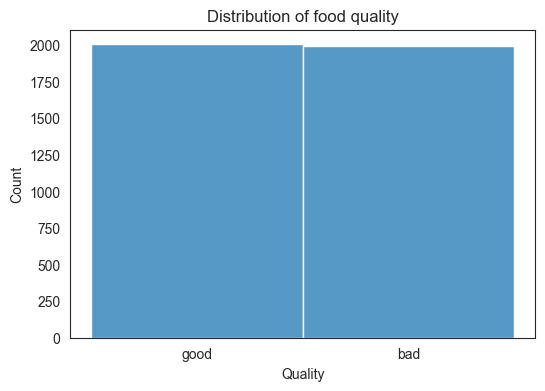

In [10]:
fig, ax = plt.subplots(figsize = (6,4))
sns.histplot(fruits['Quality'], ax = ax);
ax.set_title('Distribution of food quality')

We have an almost perfectly balanced dataset in terms of distinct values of food quality:

In [124]:
good = fruits[fruits['Quality']== 'good'].shape[0]
bad = fruits.shape[0] - good
print('Number of good fruits: {}. Number of bad fruits: {}'.format(good,bad))

Number of good fruits: 2004. Number of bad fruits: 1996


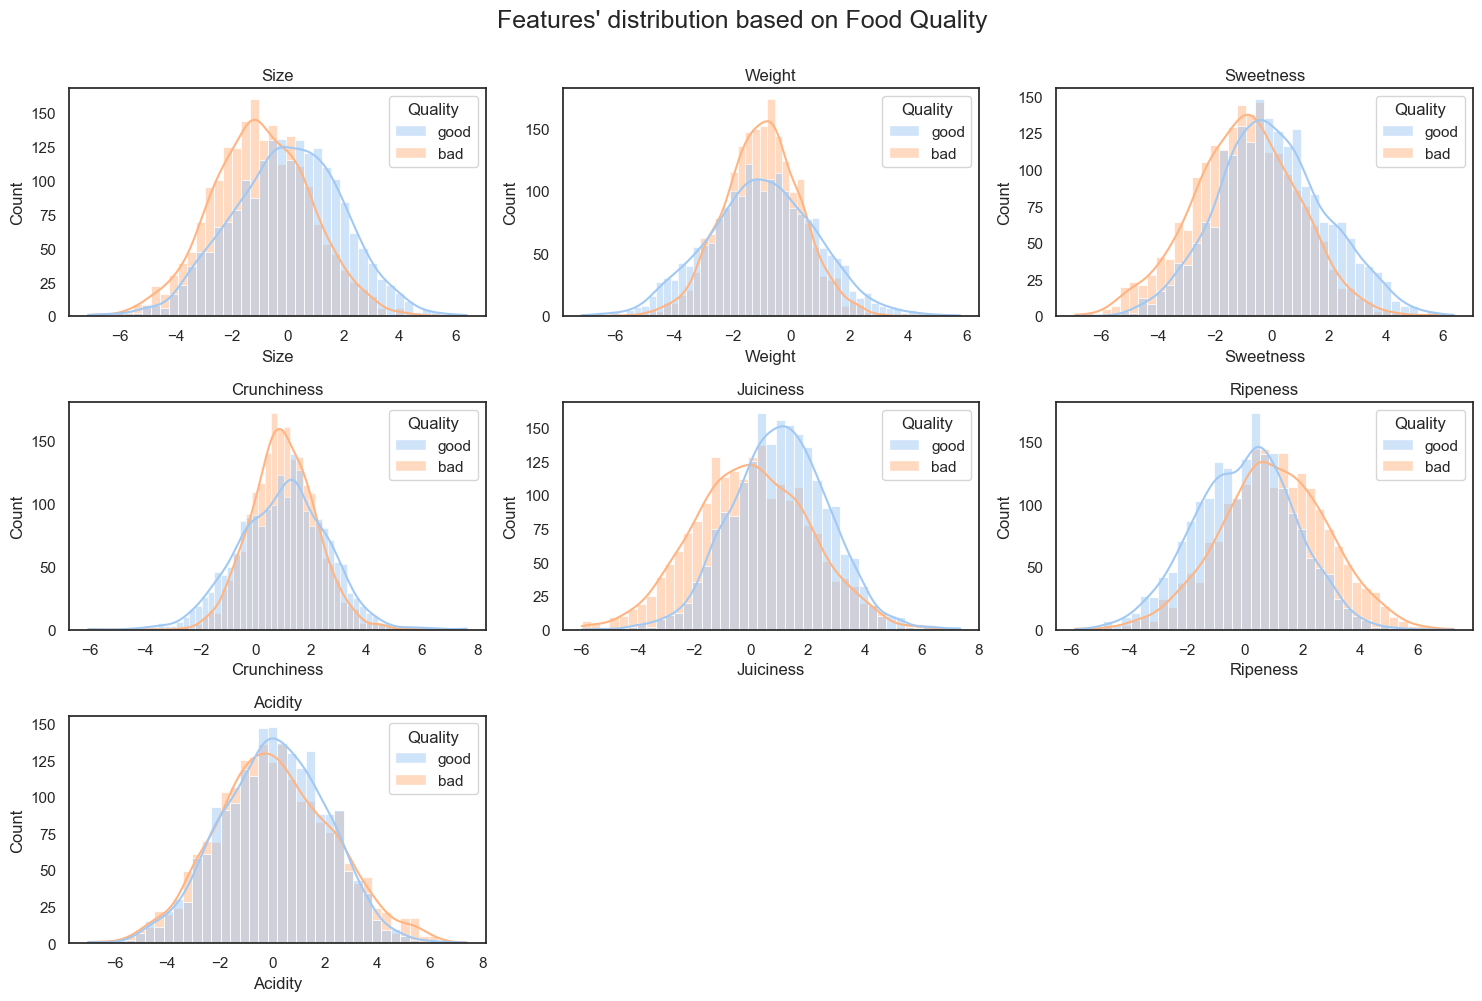

In [125]:
fig =plt.figure(figsize = (15,10))
sns.set_palette('pastel')
for i, feature in enumerate(features,1):
    plt.subplot(3,3,i)
    sns.histplot(data = fruits, x = feature, hue = 'Quality', kde = True)
    plt.title(feature)
fig.suptitle('Features\' distribution based on Food Quality', fontsize=18, y = 1)
plt.tight_layout()

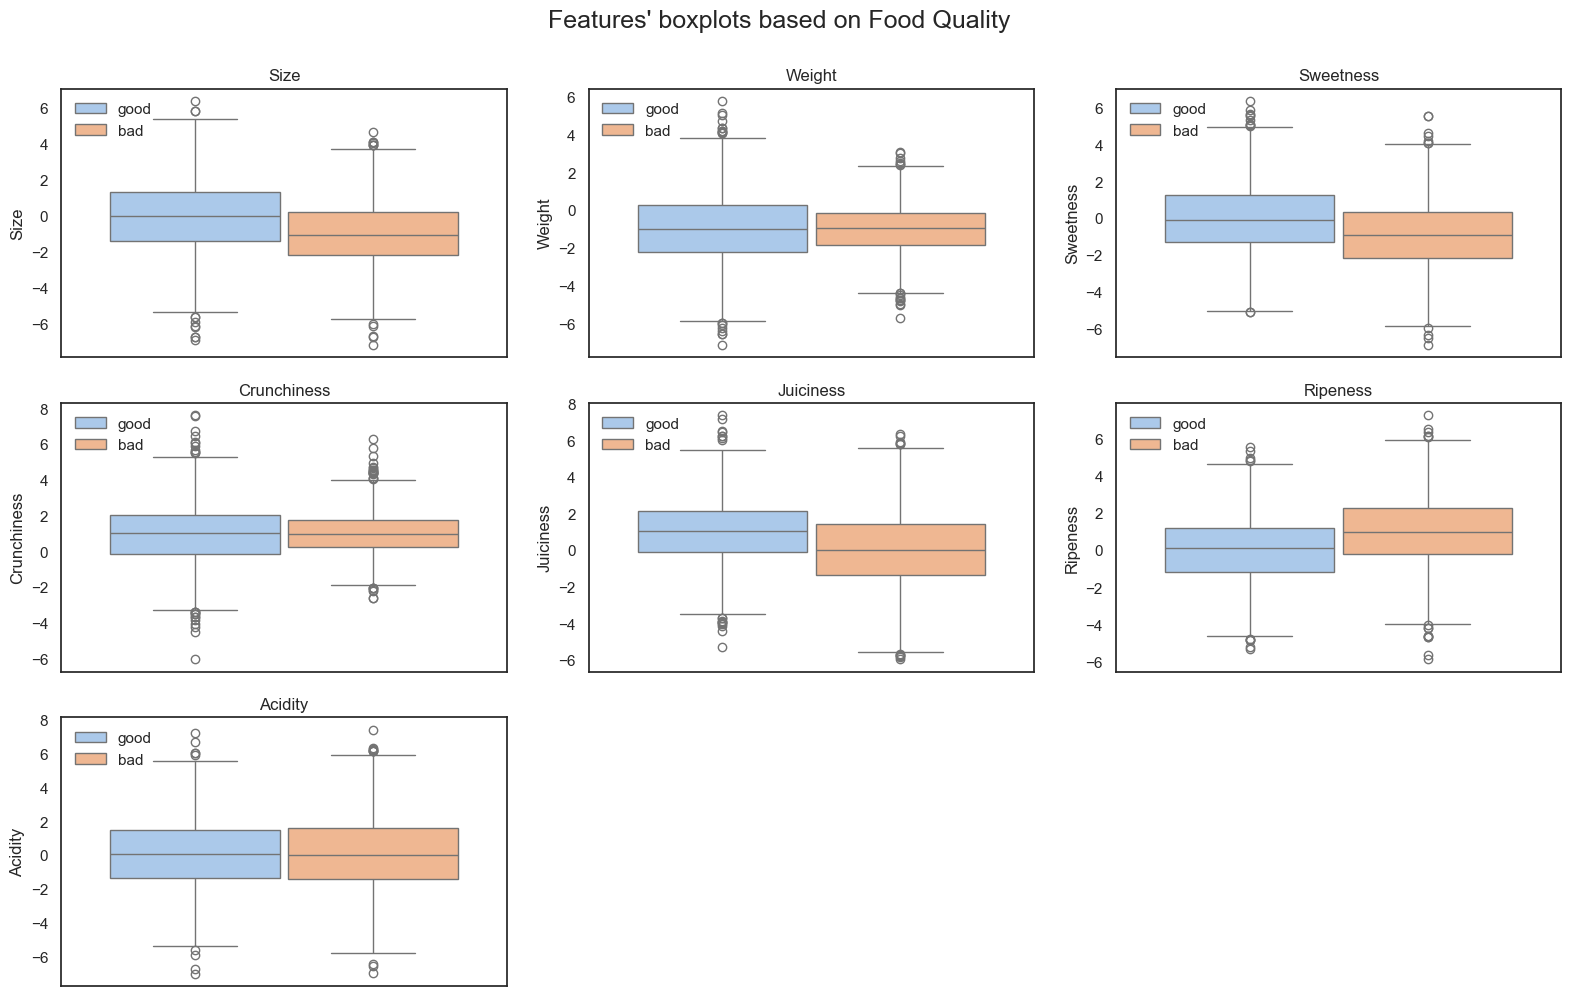

In [126]:
fig = plt.figure(figsize = (16,10))
sns.set_palette('pastel')
for i, feature in enumerate(features,1):
    plt.subplot(3,3,i)
    sns.boxplot(data = fruits, y = feature, hue = 'Quality', gap = .05)
    plt.legend(loc='upper left',frameon=False)
    plt.title(feature)
    
fig.suptitle('Features\' boxplots based on Food Quality', fontsize=18, y = 1)
plt.tight_layout()


Features' distribution changes based on food quality depending on how much data are spread along the dataset, the value of their median or on both.

We can perform some of the most common supervised classification techniques to gain more insights about the relationship between features and response. \
Some methods that I considered work better when features are all in the same scale of values, that's why it's convenient to rescale each feature.

It's also convenient to encode the Quality column with numerical values (0s and 1s)

In [15]:
fruits['Quality'] = fruits['Quality'].map({'bad':0,'good':1})

## Correlation matrix

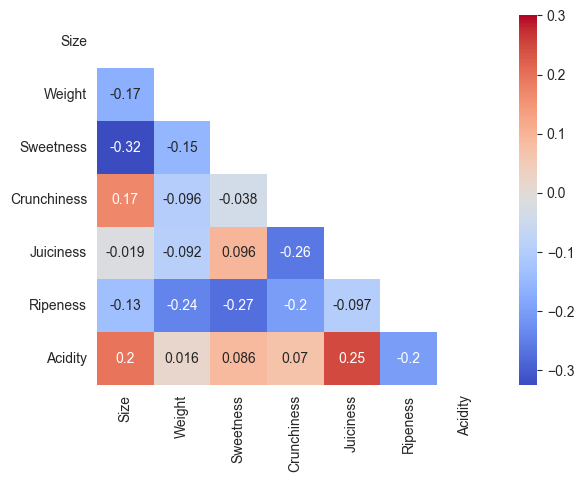

In [16]:
corr_df = fruits.drop('Quality', axis = 1).corr()
sns.heatmap(data = corr_df,annot = True,mask = np.triu(corr_df), cmap = 'coolwarm', vmax = .3);

### Training and test set split

In [17]:
features = fruits.columns.drop(['Quality'])
X, y = fruits[features], fruits['Quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101,stratify=y)

### Standardization

In [18]:
# Features rescaling
scaler = RobustScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

## Logistic Regression
***

In [19]:
# Make training and test dataset back to a Dataframe for better visualization
X_train =  pd.DataFrame(data = X_train_std, index = X_train.index,  columns = X_train.columns)
X_test =  pd.DataFrame(data = X_test_std, index = X_test.index,  columns = X_test.columns)

In [20]:
model = sm.Logit(y_train,sm.add_constant(X_train.astype(float)))
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.516034
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Quality   No. Observations:                 2800
Model:                          Logit   Df Residuals:                     2792
Method:                           MLE   Df Model:                            7
Date:                Tue, 05 Mar 2024   Pseudo R-squ.:                  0.2555
Time:                        17:27:30   Log-Likelihood:                -1444.9
converged:                       True   LL-Null:                       -1940.8
Covariance Type:            nonrobust   LLR p-value:                7.038e-210
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0140      0.046     -0.305      0.760      -0.104       0.076
Size            1.7334    

Size, Weight, Sweetness, Juiciness, Ripeness, Acidity have all statistically significant coefficients with p-values < 0.05. \
These coefficients suggest that **larger sizes, greater weights, higher levels of sweetness, juiciness, and ripeness tend to correspond to higher quality, while higher levels of acidity tend to correspond to lower quality**. \
The variable 'Cruchiness' has a coefficient of 0.0726, but its p-value (0.154) is greater than 0.05. By looking at the correlation matrix, its high p-value doesn't seem to be connected to high collinearity with other features, one can also explore this by looking at the variance inflation factor or  other relevant measures of collinearity.
Crunchiness may not have a statistically significant effect on the quality of the items in this specific model, but it doesn't exclude the possibility of a different type of relationship with food quality, so we are going to keep it in the following.

### Accuracy on test set

In [ ]:
probs = results.predict(sm.add_constant(X_test))
pred_labels = round(probs).map({0:'bad',1:'good'})
y_true = y_test.map({0:'bad',1:'good'})
print(classification_report(y_true, pred_labels))

With the logistic regression model we obtain an **accuracy of $75 \%$**, the method seems to work well for the prediction of both classes.  \
Even if the result is not great in  terms of accuracy and explainability of data (relatively small pseudo $R^{2}$) , logistic regression helps us to interpret the role of each feature variable.

In [44]:
cm =confusion_matrix(y_true, pred_labels)
cm_df = pd.DataFrame(data = cm, columns = ['Bad (Predicted)', 'Good (Predicted)'], index = ['Bad (Truth)',  'Good (Truth)'])
cm_df

,Bad (Predicted),Good (Predicted)
Bad (Truth),444,155
Good (Truth),146,455


## Random Forest classifier
***

In [53]:
rf = RandomForestClassifier()

param_grid= {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

random_rf = RandomizedSearchCV(estimator=rf, 
                  param_distributions=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  n_iter = 20,
                  cv=5,
                  random_state = 1,
                  n_jobs=-1)

In [61]:
random_rf = random_rf.fit(X_train, y_train)
print('Optimal model\'s parameters: {}  \n'.format(random_rf.best_params_))
print('Accuracy: {:.3f}'.format(random_rf.best_score_))

Optimal model's parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
Accuracy: 0.88


### Accuracy on test set

In [82]:
rf_clf = random_rf.best_estimator_
y_pred = rf_clf.predict(X_test)
y_pred = list(map(lambda x : 'good' if x else 'bad', y_pred))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         bad       0.90      0.87      0.88       599
        good       0.87      0.91      0.89       601

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



In [83]:
cm =confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(data = cm, columns = ['Bad (Predicted)', 'Good (Predicted)'], index = ['Bad (Truth)',  'Good (Truth)'])
cm_df

,Bad (Predicted),Good (Predicted)
Bad (Truth),520,79
Good (Truth),57,544


The result is greatly improved! \
Accuracy on test set: $89 \%$

### Estimate of features' importance in Random Forest model

We can look at each feature's importance measured by the Random Forests fit:

In [55]:
feature_imp = pd.DataFrame({'importance':rf.feature_importances_},index=X_train.columns)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Ripeness,0.169158
Size,0.161612
Juiciness,0.156944
Sweetness,0.155104
Acidity,0.127640
Weight,0.115389
Crunchiness,0.114154


Crunchiness does  have an impact on classification, even if its relation with the response variable is unlikely to be the one assumed in logistic regression.

Overall,all features have meaningful importance in the fit.

## Support vector machines
***

In [92]:
svm = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
}
random_svc = RandomizedSearchCV(estimator=svm, 
                  param_distributions=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  n_iter = 20,
                  cv=5,
                  random_state = 1,
                  n_jobs=-1)

In [93]:
random_svc = random_svc.fit(X_train, y_train)
print('Optimal model\'s parameters: {}'.format(random_svc.best_params_))
print('Accuracy: {:.3f}'.format(random_svc.best_score_))

Optimal model's parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 1}
Accuracy: 0.910


### Accuracy on test set

In [94]:
svc_clf = random_svc.best_estimator_

In [95]:
y_pred = svc_clf.predict(X_test)
y_pred = list(map(lambda x : 'good' if x else 'bad', y_pred))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         bad       0.92      0.91      0.91       599
        good       0.91      0.93      0.92       601

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200



In [96]:
cm =confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(data = cm, columns = ['Bad (Predicted)', 'Good (Predicted)'], index = ['Bad (Truth)',  'Good (Truth)'])
cm_df

,Bad (Predicted),Good (Predicted)
Bad (Truth),543,56
Good (Truth),45,556


The optimal SVC model found with the cross-validation approach gives the best result in classification with respect to the others that were considered, reaching an overall **accuracy of 92 %**.